# SeeFood

In [1]:
import glob 
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [2]:
def load_images(paths, dim, label_value):
    features, labels = [], []
    
    for idx, path in enumerate(paths):
        for pic in glob.glob(path, recursive=True):
            img = np.array(load_img(pic, target_size = dim))    ####PIL
            features.append(img / 255.0)
            labels.append(label_value[idx])
    
    return features, labels

In [3]:
from tensorflow.keras.applications.resnet50 import preprocess_input

def load_images2(paths, dim, label_value):
    imgs, labels = [], []
    
    for idx, path in enumerate(paths):
        for pic in glob.glob(path, recursive=True):
            img = load_img(pic, target_size=dim)
            imgs.append(np.array(img)/255.0)
            labels.append(label_value[idx])
    
    features = np.array([img_to_array(img) for img in imgs])
    
    return features, np.array(labels)
    

In [4]:
# Specify paths to the data
hot_dog_path = '..\\dataset\\hot_dog\\**/*.jpg'
not_hotdog_path = '..\\dataset\\not_hot_dog\\**/*.jpg'

image_size = 32

features, labels = load_images2([hot_dog_path, not_hotdog_path], (image_size, image_size), [1,0])

print(features.shape)
    
    

(998, 32, 32, 3)


In [5]:

# Create a random array from [0 -> len of features and labels]
s = np.arange(features.shape[0])
# shuffle it
np.random.shuffle(s)

# use that array to shuffle features and labels
# the same way so we don't lose information
features = features[s]
labels = labels[s]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)
print(features[0].shape)


(32, 32, 3)


### Verify the data


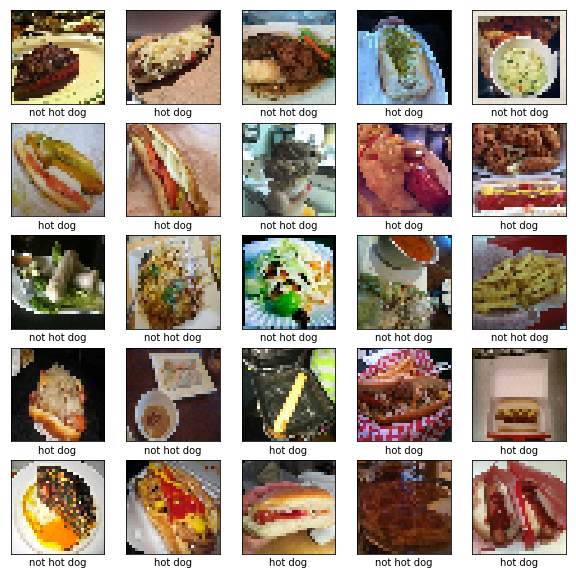

In [6]:
plt.figure(figsize=(10,10))
named_labels = ["not hot dog", "hot dog"]

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(features[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(named_labels[labels[i]])
plt.show()

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

### Add Dense layer

In [8]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

Let's see the model architecture:

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                460864    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 461,890
Trainable params: 461,890
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Train on 668 samples, validate on 330 samples
Epoch 1/10
668/668 [==============================] - 1s 952us/sample - loss: 0.7003 - accuracy: 0.5329 - val_loss: 0.6677 - val_accuracy: 0.5818
Epoch 2/10
668/668 [==============================] - 0s 330us/sample - loss: 0.6413 - accuracy: 0.6362 - val_loss: 0.6982 - val_accuracy: 0.5697
Epoch 3/10
668/668 [==============================] - 0s 304us/sample - loss: 0.6114 - accuracy: 0.6737 - val_loss: 0.6496 - val_accuracy: 0.6424
Epoch 4/10
668/668 [==============================] - 0s 302us/sample - loss: 0.5411 - accuracy: 0.7395 - val_loss: 0.6441 - val_accuracy: 0.6424
Epoch 5/10
668/668 [==============================] - 0s 305us/sample - loss: 0.4920 - accuracy: 0.7889 - val_loss: 0.6675 - val_accuracy: 0.6182
Epoch 6/10
668/668 [==============================] - 0s 300us/sample - loss: 0.4266 - accuracy: 0.8353 - val_loss: 0.7083 - val_accuracy: 0.5970
Epoch 7/10
668/668 [==============================] - 0s 300us/sample - loss: 

330/1 - 0s - loss: 1.1347 - accuracy: 0.6030


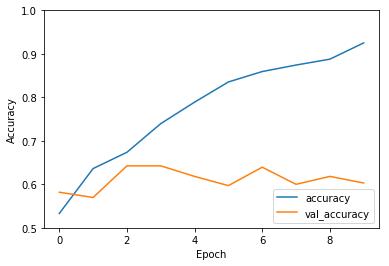

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

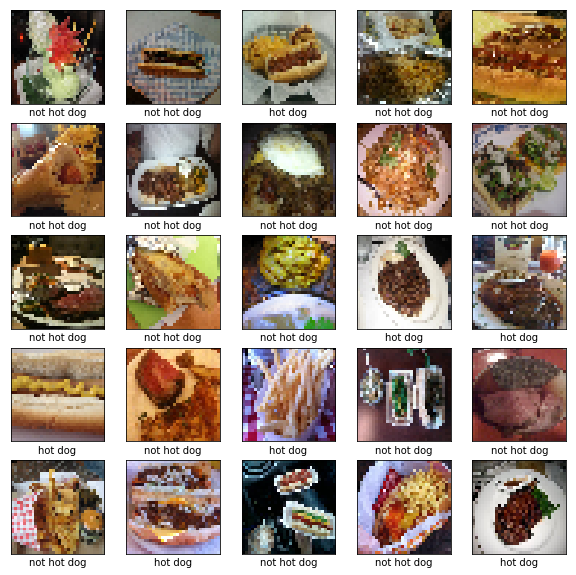

In [12]:
plt.figure(figsize=(10,10))
rez = model.predict(X_test[:25])
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    plt.xlabel(named_labels[np.argmax(rez[i])])
plt.show()